### Which model is the best?
1) GradientBoostingRegressor

2) XGBRegressor

3) LGBMRegressor

4) RandomForestRegressor

In [ ]:

random_state = 2021
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    for model in models:
    # 모델 이름 획득
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        X_train = X_train.fillna(X_train.mean())
        X_test = X_test.fillna(X_train.mean())
        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
	
    return score_df

get_scores(models,X_train, y_train)

[00:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
RandomForestRegressor,0.599247
XGBRegressor,0.527956
GradientBoostingRegressor,0.527060
LGBMRegressor,0.464281


# Let's try LGBM and XGB Model

## 1)Recurrent Feature elimination

특징을 가장 잘 추출해주는 feature들을 impotance에 따라 지워 나가며 최적의 feature들을 남겨놓습니다.

## Apply **rfe function** of two regressor (by importance)

,importance
day_of_year,0.221812
air_genre_name,0.137641
longitude,0.104507
street,0.100110
latitude,0.096341
city,0.081972
weekday,0.078204
n_stores_same_street,0.065013
max_reserve_visitors,0.057632
n_reserve_visitors,0.027795


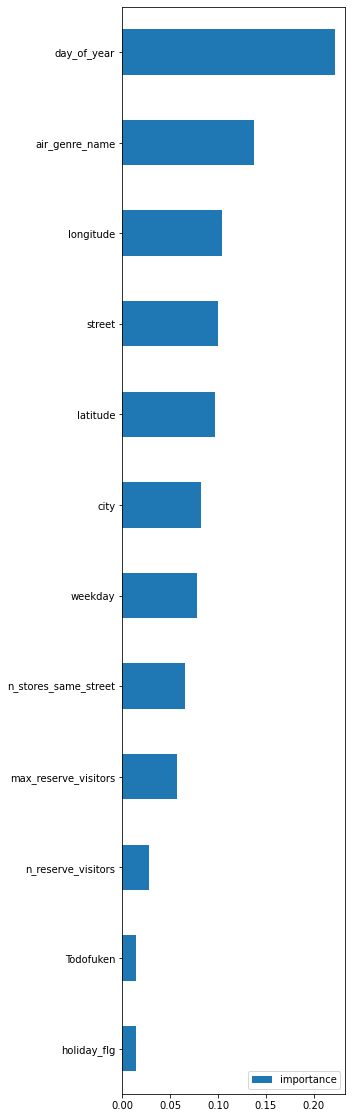

In [ ]:

feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index')
feature_importance.columns = ['importance']
feature_importance.importance = feature_importance.importance / feature_importance.importance.sum()
feature_importance.sort_values(by='importance').head(30).plot.barh(figsize=[4,20])
feature_importance.sort_values(by='importance', ascending=False).head(30)

In [ ]:

import eli5
from eli5.sklearn import PermutationImportance
import gc
def rfe(x_data, y_data, method, model_name, ratio=0.9, min_feats=16):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        if model_name =='LGBM':
          model = LGBMRegressor(objective='regression', num_iterations=10**5)
        elif model_name=='XGB':
          model = XGBRegressor(num_iterations=10**5)
        
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse(val_pred, y_val)##rmse score
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

feats = [col for col in X_train.columns]
len(feats)

21

In [ ]:
X_train1 = X_train[feats]
basic_archive_LGBM = rfe(X_train1, y_train, 'basic',model_name='LGBM')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


21 0.43587740350627535


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


18 0.4365778720908273


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


16 0.43669771711436295


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


14 0.4367382649356829


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


12 0.44381295953272193


In [ ]:
basic_archive_XGB = rfe(X_train1, y_train, 'basic',model_name ='XGB')

[01:01:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
21 0.5307475554802574
[01:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
18 0.5307475554802574
[01:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
16 0.5301289911200544
[01:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
14 0.5309908630288127
[01:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
12 0.5315610657521656


In [ ]:
X_train1 = X_train[feats]
perm_archive_LGBM = rfe(X_train1, y_train, 'perm',model_name ='LGBM')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


21 0.43587740350627535


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


18 0.4354179975134991


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


16 0.43517015753410215


In [ ]:
perm_archive_XGB = rfe(X_train1, y_train, 'perm',model_name ='XGB')

[01:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
21 0.5307475554802574
[01:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
18 0.5307475554802574
[01:04:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
16 0.5306969020149792
[01:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
14 0.5325722958685459
[01:04:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
12 0.530665421259944


In [ ]:
#XGB
min_index_xgb = perm_archive_XGB['score'].argmin()
filtered_column_xgb = perm_archive_XGB['feats'][min_index_xgb]
fin_score_xgb = perm_archive_XGB['score'][min_index_xgb]
print(filtered_column_xgb)
print(len(filtered_column_xgb))
# lgbm
min_index_lgbm = perm_archive_LGBM['score'].argmin()
filtered_column_lgbm = perm_archive_LGBM['feats'][min_index_lgbm]
fin_score_lgbm = perm_archive_LGBM['score'][min_index_lgbm]
print(filtered_column_lgbm)

['air_genre_name', 'weekday', 'n_reserve_visitors', 'city', 'max_reserve_visitors', 'longitude', 'latitude', 'street', 'n_stores_same_street', 'Todofuken', 'holiday_flg', 'day_of_year']
12
['air_genre_name', 'weekday', 'longitude', 'n_reserve_visitors', 'n_stores_same_street', 'max_reserve_visitors', 'street', 'city', 'day_of_year', 'latitude', 'year', 'n_stores_same_city', 'holiday_flg', 'n_stores_same_Todofuken', 'tomorrow_is_holiday', 'Todofuken']


In [ ]:
X_train_xgb = X_train[filtered_column_xgb] ##Filtered by rfe
X_val_xgb = X_val[filtered_column_xgb]
#
X_train_lgbm =X_train[filtered_column_lgbm]
X_val_lgbm = X_val[filtered_column_lgbm]